In [1]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
np.set_printoptions(precision = 2)
np.random.seed(0)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
num_nodes = 7
B = np.array([[0., 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0, 0, 0], [0, 1, 1, 0, 0, 0, 0], [0, 1, 0, 1, 0, 0, 0], [0, 0, 1, 1, 0, 0, 0], [0, 0, 0, 0, 1, 1, 0]])
target = 4
total_envs_list = [3,5,8,11,14,17,20]
sites = [2,3,5]
strength = 1
radius = 0.02
nv = 0.02
num_test_envs = 100

In [3]:
def subset_generator():
    for i in range(2**(num_nodes-1)):
        s = []
        for ind in range(num_nodes-1):
            if (i>>ind)%2 == 1:
                s.append(ind)
        yield s
    


In [4]:
def indirect_soft_intervention_data(S, B, sites, v, num_nodes, num_data, noise_variance):
    B_intervention = np.copy(B)
    for site in sites:
        for row in range(num_nodes):
            B_intervention[site, row] *= np.random.normal(0, v)
    U = np.random.normal(0, noise_variance, (num_nodes,num_data))
    X = np.linalg.inv(np.eye(num_nodes) - B_intervention)@U
    y = X[target, :]
    x = np.delete(X, target, 0)
    x = S@x
    return(x, y)

def soft_intervention_data(B, sites, v, num_nodes, num_data, noise_variance):
    B_intervention = np.copy(B)
    for site in sites:
        for row in range(num_nodes):
            B_intervention[site, row] *= np.random.normal(0, v)
    U = np.random.normal(0, noise_variance, (num_nodes,num_data))
    X = np.linalg.inv(np.eye(num_nodes) - B_intervention)@U
    
    return(X)

def hard_intervention_data(B, sites, v, num_nodes, num_data, noise_variance):
    B_intervention = np.copy(B)
    B_intervention[sites, :] = 0
    U = np.random.normal(0, noise_variance, (num_nodes,num_data))
    interventions = np.random.normal(0, v, (len(sites), 1))
    U[sites, :] = np.squeeze(np.array([interventions for i in range(num_data)])).T
    X = np.linalg.inv(np.eye(num_nodes) - B_intervention)@U
    return(X)
    
def rademacher_intervention_data(B, strength, num_nodes, num_data, noise_variance):
    temp_B = np.where(np.random.rand(num_nodes)>strength, B, -B)
    temp_B[target] = np.abs(temp_B[target])
    U = np.random.normal(0, noise_variance, (num_nodes,num_data))
    X = np.linalg.inv(np.eye(num_nodes) - temp_B)@U
    return(X)

def obs_data(B, num_data):
    U = np.random.rand(num_nodes,num_data)-0.5
    X = np.linalg.inv(np.eye(num_nodes) - B)@U
    return(X)

def beta_processing(betas):
    rms = 0
    for i in range(len(betas)):
        for j in range(len(betas)):
            rms += np.linalg.norm(betas[i]-betas[j])
    rms /= (len(betas)**2)
    mean = np.mean(betas, axis = 0)
    flag = False
    max_abs_betas = np.max(np.abs(betas), axis = 0)
    if np.min(max_abs_betas) < 0.0001:
        flag = True
    return (rms, np.reshape(mean, (1, -1)), flag)

def create_env(data, spurious_parent, total_envs):
    thresholds = [np.percentile(data[spurious_parent], 100/(total_envs)*i) for i in range(total_envs+1)]
    envs = [np.array([data[:, i] for i in range(num_data) if (data[spurious_parent, i] > thresholds[j] and data[spurious_parent, i] <= thresholds[j+1])]).T for j in range(total_envs)]
    return (envs)

In [5]:
def solve(tr, te, num_data, ir):
    for env_index in range(len(total_envs_list)):
        total_envs = total_envs_list[env_index]
        envs = 0
        if tr == 'hard':
            envs = [hard_intervention_data(B, sites, strength, num_nodes, num_data, nv) for i in range(total_envs)]
        elif tr == 'soft':
            envs = [soft_intervention_data(B, sites, strength, num_nodes, num_data, nv) for i in range(total_envs)]

        y = [env[target, :] for env in envs]
        x = [np.delete(env, target, 0) for env in envs]
        generator = subset_generator()
    #     num_good_envs = []
    #     ERM_good_envs = []
        for subset in generator:
            if subset == []:
                continue
            betas = np.zeros((total_envs, len(subset)))
            for i in range(total_envs):
                betas[i] = np.reshape(np.linalg.lstsq(x[i][subset].T, np.reshape(y[i], (-1, 1)), rcond = None)[0], (1, -1))
            (beta_rms, beta_mean, flag) = beta_processing(betas)

            if beta_rms < radius*np.linalg.norm(beta_mean):
    #             good_betas_hard += [beta_mean]
                num_test_envs = 100
                good_envs = 0
                for test_index in range(num_test_envs):
                    env = 0
                    if te == 'hard':
                        env = hard_intervention_data(B, sites, strength, num_nodes, num_data, nv)
                    elif te == 'soft':
                        env = soft_intervention_data(B, sites, strength, num_nodes, num_data, nv)
                    elif te == 'rad':
                        env = rademacher_intervention_data(B, 0.5, num_nodes, num_data, nv)
                    
                    test_y = env[target, :]
                    test_x = np.delete(env, target, 0)
                    beta = np.reshape(np.linalg.lstsq(test_x[subset].T, np.reshape(test_y, (-1, 1)), rcond = None)[0], (1, -1))
                    
                    if np.linalg.norm(beta-beta_mean) < radius*np.linalg.norm(beta_mean):
                        good_envs += 1

                print(good_envs, end = " ")
                ir = ir.append({'good_envs' : good_envs, 'num_training_interventions' : total_envs, 'intervention' : tr+"+"+te}, ignore_index = True)
        print(" ")
    return ir

In [6]:
def solve_ERM(te, num_data, ir):
    for env_index in range(len(total_envs_list)):
        total_envs = total_envs_list[env_index]
        envs = [hard_intervention_data(B, sites, strength, num_nodes, num_data, nv) for i in range(total_envs)]

        y = [env[target, :] for env in envs]
        x = [np.delete(env, target, 0) for env in envs]

        obs_x = np.hstack(x)
        obs_y = np.hstack(y)
        obs_beta = np.reshape(np.linalg.lstsq(obs_x.T, np.reshape(obs_y, (-1, 1)), rcond = None)[0], (1, -1))
        ERM_envs = 0
        for test_index in range(num_test_envs):
            env = hard_intervention_data(B, sites, strength, num_nodes, num_data, nv)
            test_y = env[target, :]
            test_x = np.delete(env, target, 0)
            ERM_beta = np.reshape(np.linalg.lstsq(test_x.T, np.reshape(test_y, (-1, 1)), rcond = None)[0], (1, -1))
            if np.linalg.norm(ERM_beta-obs_beta) < radius*np.linalg.norm(obs_beta):
                ERM_envs += 1
#             num_good_envs += [good_envs]
#             ERM_good_envs += [ERM_envs]
        ir = ir.append({'good_envs' : ERM_envs, 'num_training_interventions' : total_envs, 'intervention' : "ERM+hard"}, ignore_index = True)
    return ir


In [7]:
def PACIRM_plot(irs, name):
    fig, axs = plt.subplots(2, 2, sharex = True, sharey = True, figsize=(16,12))
    sns.set(style="ticks")
#     titles = ["N = 10000", "N = 15000", "N = 30000", "N = 45000"]
    order = ['hard+hard', 'hard+rad', 'soft+soft', 'soft+rad', 'ERM+hard']
    sns.boxplot(x="num_training_interventions", y="good_envs", hue="intervention",hue_order = order ,data=irs[0],width=0.5,palette="PRGn",linewidth=1, ax = axs[0, 0])
    sns.boxplot(x="num_training_interventions", y="good_envs", hue="intervention",hue_order = order ,data=irs[1],width=0.5,palette="PRGn",linewidth=1, ax = axs[0, 1])
    sns.boxplot(x="num_training_interventions", y="good_envs", hue="intervention",hue_order = order ,data=irs[2],width=0.5,palette="PRGn",linewidth=1, ax = axs[1, 0])
    sns.boxplot(x="num_training_interventions", y="good_envs", hue="intervention",hue_order = order ,data=irs[3],width=0.5,palette="PRGn",linewidth=1, ax = axs[1, 1])
    axs[0,0].get_legend().remove()
    axs[0,1].get_legend().remove()
    axs[1,0].get_legend().remove()
    axs[0,0].set_title("N = 10000")
    axs[0,1].set_title("N = 15000")
    axs[1,0].set_title("N = 30000")
    axs[1,1].set_title("N = 45000")
    for ax in axs.flat:
        ax.set(xlabel="number of training interventions", ylabel='generalization percentage')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    for ax in axs.flat:
        ax.label_outer()

    plt.savefig(name, dpi = 300)
    plt.show()

In [8]:
num_data_list = [10000, 15000, 30000, 45000]
irs = []
for num_data in num_data_list:
    ir = pd.DataFrame(columns = ['good_envs', 'num_training_interventions', 'intervention'])
    ir = solve('hard', 'hard', num_data, ir)
    ir = solve('hard', 'rad', num_data, ir)
    ir = solve('soft', 'soft', num_data, ir)
    ir = solve('soft', 'rad', num_data, ir)
    ir = solve_ERM('rad', num_data, ir)
    
    irs += [ir]

99 94 99 90  
99 93 100 79  
97 96 100 87  
98 97 100 90  
99 95 99 91  
100 91 100 89  
100 92 99 92  
0 0 99 67  
0 0 100 73  
0 0 99 78  
0 0 100 84  
0 0 98 83  
0 0 98 83  
0 0 99 81  
86 50 72 49 70 54 60  
95 51 89 63 83 53 46 37  
95 84 90 61 82 70 74  
97 83 84 85  
95 84 84 92  
99 75 90 86  
99 80 92 79  
96 80 90 68 15 12  
97 83 83 62 90 64 68 36 16 9 11  
98 71 83 85 72 53 18 15  
98 80 75 89 20  
97 88 90 26  
99 82 77 59 90 62 69 21 24 9  
97 76 79 90 69 25  
99 97 100 93  
100 95 99 97  
99 98 99 97  
99 97 100 95  
98 99 100 97  
98 98 99 94  
100 99 99 95  
0 0 99 81  
0 0 100 81  
0 0 99 96  
0 0 100 93  
0 0 100 91  
0 0 99 95  
0 0 100 88  
99 93 95 93 81 82 79 73 71 60  
96 86 81 59 94 73 76 48 78 63 70  
100 97 92 80 93 80 87 74  
99 92 94 85 78 67  
97 94 93 79 94 87 87 71 66  
99 89 92 95 91 86 73 74  
99 97 92 78 97 91 87 94 72  
100 80 90 52 96 60 80 37 30 14 9 6  
99 91 97 67 95 79 75 53 18 19  
99 87 96 79 95 79 82 17 15 19 12  
100 87 90 79 96 87 75 20  


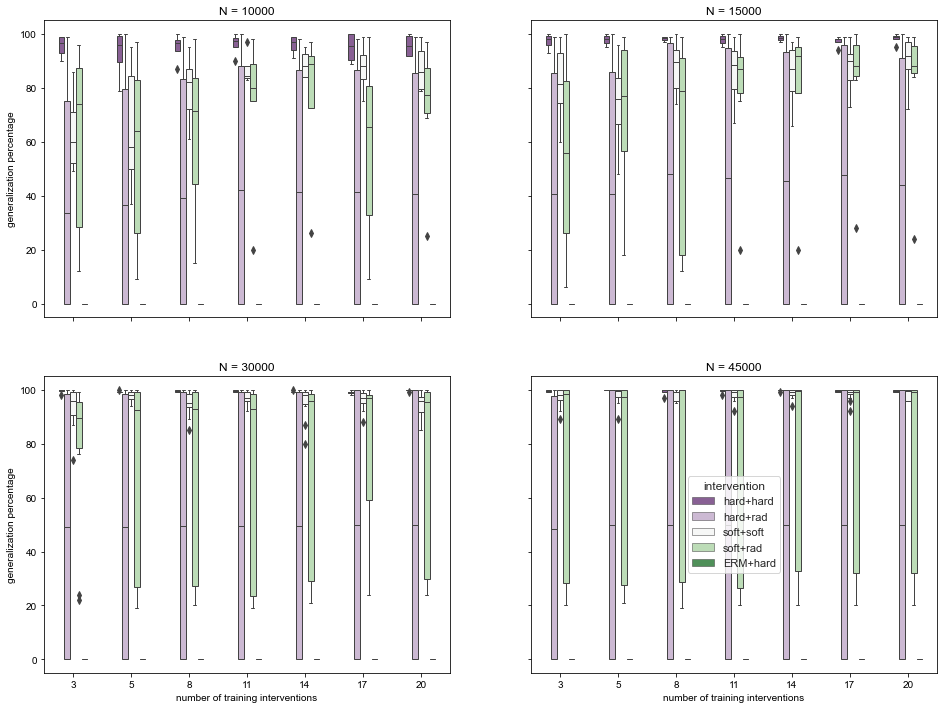

In [9]:
PACIRM_plot(irs, "PACIRM.pdf")